# Drop-out experiments

# Imports and Load Individual Models

In [28]:
# basic
import os
import pandas as pd
import re
import numpy as np

# see functions.py for a collection of self-written functions for analysing and visualising my models
from functions import *

# cobra & micom
from cobra.io import read_sbml_model
from cobra.flux_analysis import pfba
from cobra.medium import minimal_medium
from cobra.exceptions import Infeasible, OptimizationError
from micom import Community
from micom.problems import cooperative_tradeoff

# plots
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import seaborn as sns
import matplotlib.colors as mcolors

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# Load SBML Models
models_path = "../Models/12_gap_filled/"
models = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3])
    models[name] = model

models = {key: models[key] for key in sorted(models.keys())}  # sorts the dictionary alphabetically
AA1, AA2, AA3, AA4, AA5, AA6, AA7 = [models[f"AA{i}"] for i in range(1, 8)]

Restricted license - for non-production use only - expires 2026-11-23


# Functions

In [17]:
# similar to the get_pfba_fluxes function from my .py file but slighly altered to direvtly also get growth values which is valuable in this notebook for future drop out heatmaps
def community_pfba(com_model, medium):
    with model:
        change_medium(com_model, medium)
        try:
            fluxes = com_model.cooperative_tradeoff(pfba=True, fluxes=True).fluxes.transpose()
        except (Infeasible, OptimizationError):
            print(f"Model {com_model.id} is infeasible.")
            return None, None

        growth = fluxes[fluxes.index.str.contains("Growth")].transpose()
        growth = growth[~ growth.index.str.contains("medium")]
        growth.index.name = "model"
        growth = growth["Growth"]
        #print(com_model.id, growth)

        return fluxes, growth

# Medium

In [3]:
m9 = pd.read_csv("../Datasets/Medium/medium_M9.csv", sep=";")
m9_rxn = list(m9["reaction"])

In [4]:
medium_combined_naveed = pd.read_csv("../Datasets/Medium/medium_combined_Naveed_M9.csv", sep=";", quotechar='"')
medium_combined_krumbach= pd.read_csv("../Datasets/Medium/medium_combined_Krumbach_M9.csv", sep=";", quotechar='"')

In [5]:
ecoplate = pd.read_csv("../Datasets/Medium/medium_ecoplate_carbon.csv", sep=";", quotechar='"')
ecoplate_rxns = [safe_parse(x) for x in ecoplate["reaction"]]

In [6]:
ecoplate_short = pd.read_csv("../Datasets/Medium/medium_ecoplate_carbon_shortened.csv", sep=";", quotechar='"')
ecoplate_rxns_short = [safe_parse(x) for x in ecoplate_short["reaction"]]

# Create C7 Community Model with MICOM

In [7]:
taxonomy = pd.read_csv("../Datasets/community_model_gap_filled.csv", sep=";")
syncom = Community(taxonomy.iloc[:, :-1], name="synthetic seven member bacterial community", id="C7", solver="cplex")

Output()

In [8]:
# change lower bound of Exchange reactions (EX between bacteria and medium)
for rxn in syncom.reactions.query("^EX_"):
    rxn.lower_bound = -1000

# Create Drop-out Communities
From our C7 community we want to exclude one bacterium at a time making it a C6 community

In [10]:
syncoms = {}

for i in range(len(taxonomy)):
    cut_tax = taxonomy.drop(index=taxonomy.index[i])
    name = f"syncom_drop{i+1}"

    com = Community(
        cut_tax.iloc[:, :-1],
        name="synthetic six member bacterial community",
        id=name,
        solver="cplex")

    # Set EX reaction bounds for this syncom
    for rxn in com.reactions.query("^EX_"):
        rxn.lower_bound = -1000  # make exchange freely available

    syncoms[name] = com

S1, S2, S3, S4, S5, S6, S7 = [syncoms[f"syncom_drop{i+1}"] for i in range(7)]

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [11]:
all_models = {**syncoms, 'C7_Community': syncom}

# Growth for all drop-out syncoms

In [12]:
test_medium(syncom, medium_combined_krumbach)

model
AA1    17.872157
AA2    18.809741
AA3    14.676299
AA4    14.640428
AA5    15.018397
AA6    14.938410
AA7    15.187845
Name: Growth, dtype: float64

In [13]:
test_medium(syncom, medium_combined_naveed)

model
AA1    12.782515
AA2    14.596887
AA3     0.000170
AA4    33.077317
AA5    19.563136
AA6    17.982364
AA7    21.346332
Name: Growth, dtype: float64

In [17]:
for model in all_models.values():
    print(test_medium(model, medium_combined_krumbach))

model
AA2    20.995824
AA3    12.912899
AA4    14.621185
AA5    13.380431
AA6    14.681867
AA7    15.110819
Name: Growth, dtype: float64
model
AA1    17.339245
AA3    14.877365
AA4    15.183806
AA5    15.323560
AA6    15.301576
AA7    15.400286
Name: Growth, dtype: float64
model
AA1    17.362514
AA2    18.763093
AA4    17.203504
AA5    17.367572
AA6    16.833443
AA7    17.439878
Name: Growth, dtype: float64
model
AA1    19.000933
AA2    18.948917
AA3    10.071253
AA5    17.934955
AA6    18.290222
AA7     8.142352
Name: Growth, dtype: float64
model
AA1    17.281426
AA2    17.784580
AA3    12.861368
AA4    15.079412
AA6    15.261536
AA7    15.452583
Name: Growth, dtype: float64
model
AA1    17.807310
AA2    17.618129
AA3    13.798409
AA4    14.553767
AA5    14.066843
AA7    15.083033
Name: Growth, dtype: float64
model
AA1    17.369746
AA2    17.275897
AA3    14.340583
AA4    14.408890
AA5    14.665969
AA6    14.914126
Name: Growth, dtype: float64
model
AA1    17.873104
AA2    18.810325
A

In [26]:
def heatmap_growth_dropouts(models, medium, medium_name, save_path=None):
    # Include full 7-member community
    growth_data = {}

    for name, syncom in models.items():
        _, growth = community_pfba(syncom, medium)
        if growth is not None:
            growth_data[name] = growth

    # Combine into DataFrame
    growth_df = pd.DataFrame(growth_data).transpose()

    epsilon = 1e-6
    growth_df = growth_df.applymap(lambda x: 0 if abs(x) < epsilon else x)
    # sort to put full community on top
    growth_df = growth_df.sort_index(key=lambda x: x.str.replace("C7_Community", "0"), axis=0)

    plt.figure(figsize=(10, 6))
    sns.heatmap(
        growth_df.T,  # Transpose the DataFrame
        fmt=".3f",
        annot=True,
        cmap="Reds",
        cbar_kws={'label': 'Flux through Biomass\n[mmol/(gDW h)]'}
    )
    plt.title(f"Growth per strain across community model variants (including full community)\non {medium_name} medium")
    plt.xlabel("Community variant")  # flipped axes
    plt.ylabel("Strains")            # flipped axes
    plt.tight_layout()
    if save_path is not None:
        file_name = f"drop_outs_growth_{medium_name}.svg"
        plt.savefig(f"../Figures/{file_name}", format="svg", bbox_inches="tight")
    plt.show()

    return growth_df

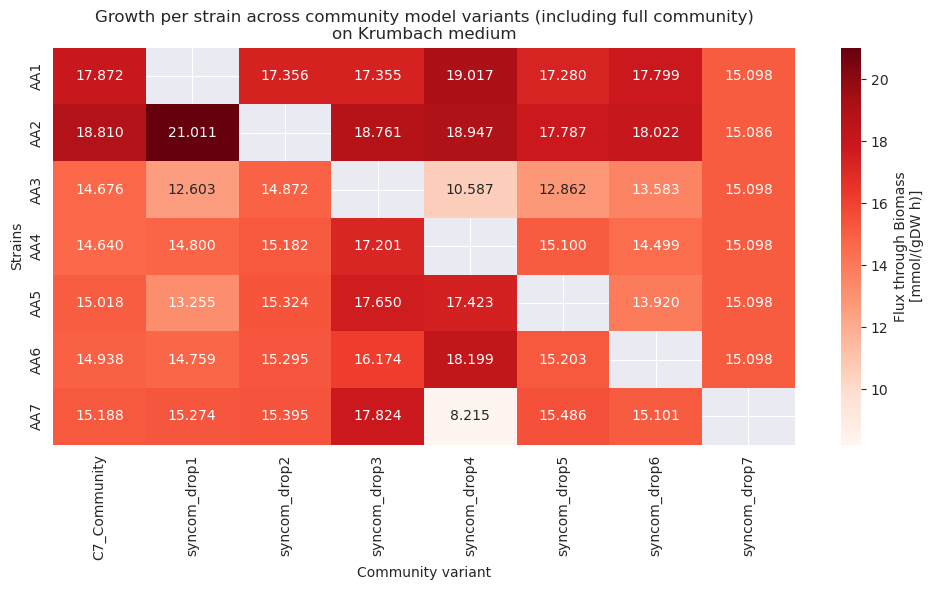

In [27]:
growth_krumbach_df = heatmap_growth_dropouts(all_models, medium_combined_krumbach, "Krumbach")

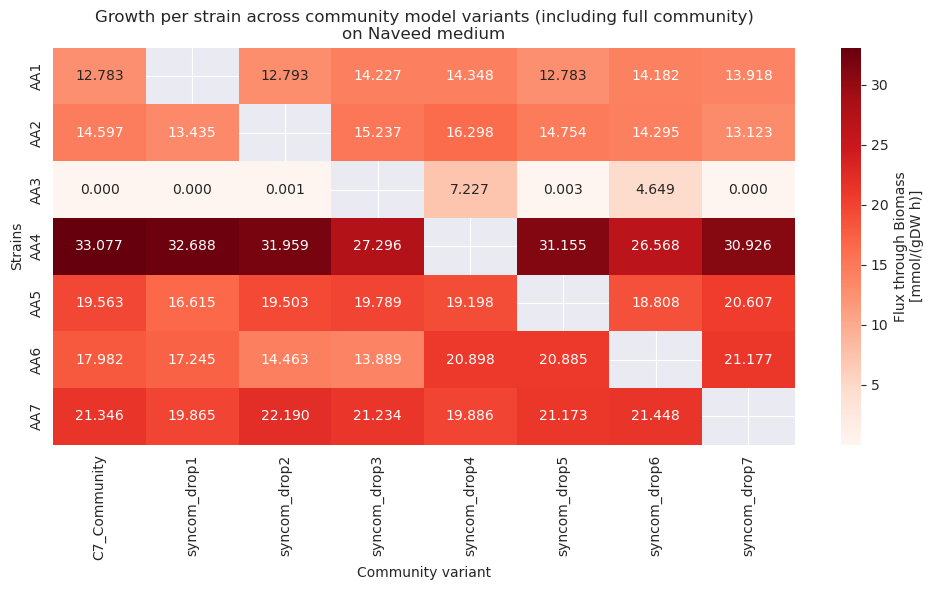

In [32]:
growth_naveed_df = heatmap_growth_dropouts(all_models, medium_combined_naveed, "Naveed")

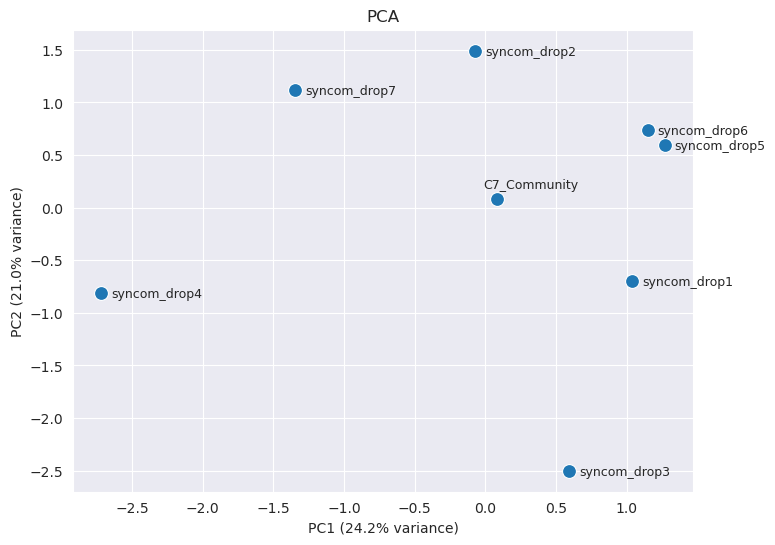

In [30]:
pca(growth_krumbach_df)

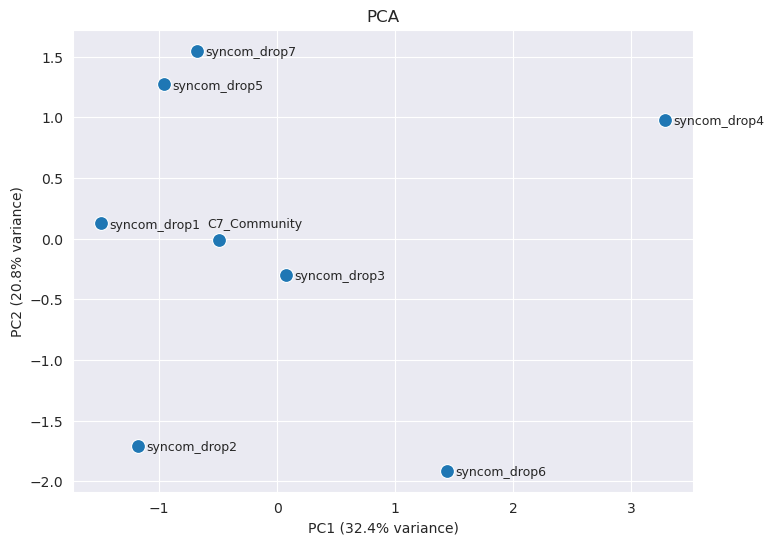

In [33]:
pca(growth_naveed_df)

# Substrate Utilisation (BIOLOG Ecoplate)

def create_medium(carbon_list, minimal_list, model_dict, medium_uptake_bound, carbon_only = False):

[08/08/25 16:26:56] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=42237;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=263930;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[08/08/25 16:26:59] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=254006;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=43567;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[08/08/25 16:27:01] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=223680;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=109325;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[08/08/25 16:27:03] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=372409;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=244851;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[08/08/25 16:27:05] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=571060;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=511718;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[08/08/25 16:27:07] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=473757;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=32793;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[08/08/25 16:27:08] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=704773;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=45756;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[08/08/25 16:27:10] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=203249;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=115230;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

Heatmap saved to ../Figures/drop_outs_ecoplate_total_new.svg


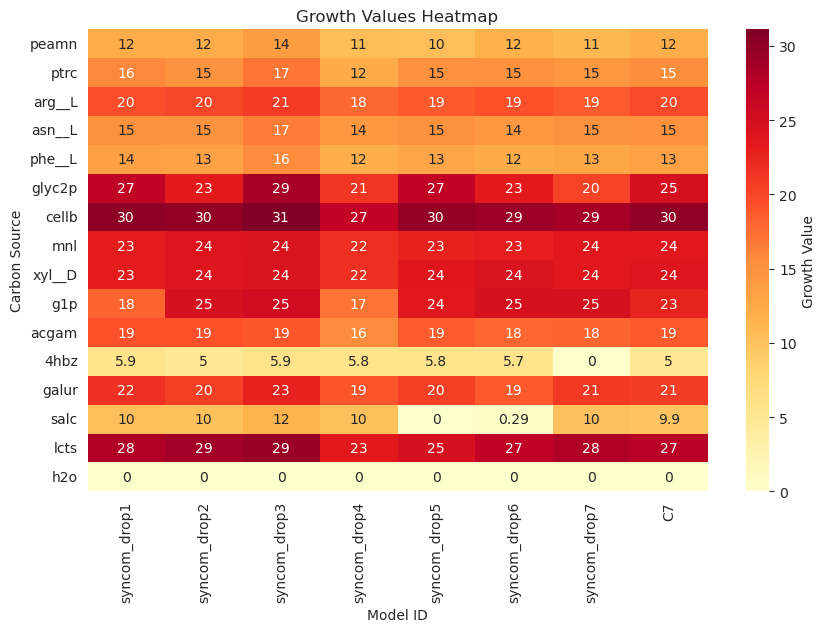

In [26]:
res_df_total = create_medium(ecoplate_rxns_short, m9_rxn, all_models, 10, carbon_only=True, average="yes")
# takes around 9min

In [22]:
res_df_avg = create_medium(ecoplate_rxns, m9_rxn, all_models, 10, carbon_only=True, save_path="../Figures/drop_outs_ecoplate_newhigh.svg", average="yes")

KeyboardInterrupt: 

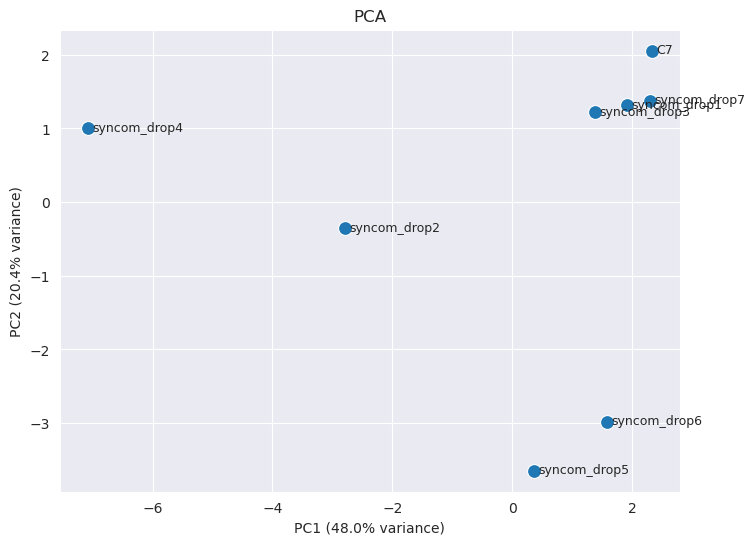

In [33]:
pca(res_df_avg.T)

# Combine Heatmaps

In [26]:
growth_with_total = growth_krumbach_df.copy()

# First calculate the raw sum
growth_with_total["Total"] = growth_with_total.sum(axis=1)

# Adjust Total based on the index
def adjust_total(row):
    if "drop" in row.name:
        return row["Total"] / 6
    elif row.name == "C7_Community":
        return row["Total"] / 7
    else:
        return row["Total"]  # Leave unchanged if none of the above

# Apply the adjustment
growth_with_total["Total"] = growth_with_total.apply(adjust_total, axis=1)


In [27]:
# Create a mask for the last row ("Total")
mask_top = np.zeros_like(growth_with_total.T, dtype=bool)
mask_top[-1, :] = True  # mask the last row to avoid color distortion

In [28]:
# Custom axis labels
custom_labels_y = ["C7", "C6-Sma", "C6-Bpi", "C6-Cpu", "C6-Elu", "C6-Cin", "C6-Hro", "C6-Ppu"]
custom_labels_x = ["Sma", "Bpi", "Cpu", "Elu", "Cin", "Hro", "Ppu", "Community mean"]
#metab_axis = ["Phenylethylamine", "Putrescine", "Glycyl-glutamic acid", "L-arginine", "Asparagine", "Phenylalanine", "Serine", "Threonine", "Glycerol-phosphate", "Cellobiose", "mannitol", "Xylose", "Glucose-1-phosphate", "Acetyl-glucosamine", "Galacturonic acid", "Malic acid", "2-Hydroxy-benzoic acid", "Lactose", "Butyric acid", "Water (Control)"]
metab_axis = ["Phenylethylamine", "Putrescine", "L-arginine", "Asparagine", "Phenylalanine", "Glycerol-phosphate", "Cellobiose", "Mannitol", "Xylose", "Glucose-1-phosphate", "Acetyl-glucosamine", "Galacturonic acid", "2-Hydroxy-benzoic acid", "Lactose", "Water (Control)"]

ValueError: The number of FixedLocator locations (20), usually from a call to set_ticks, does not match the number of labels (15).

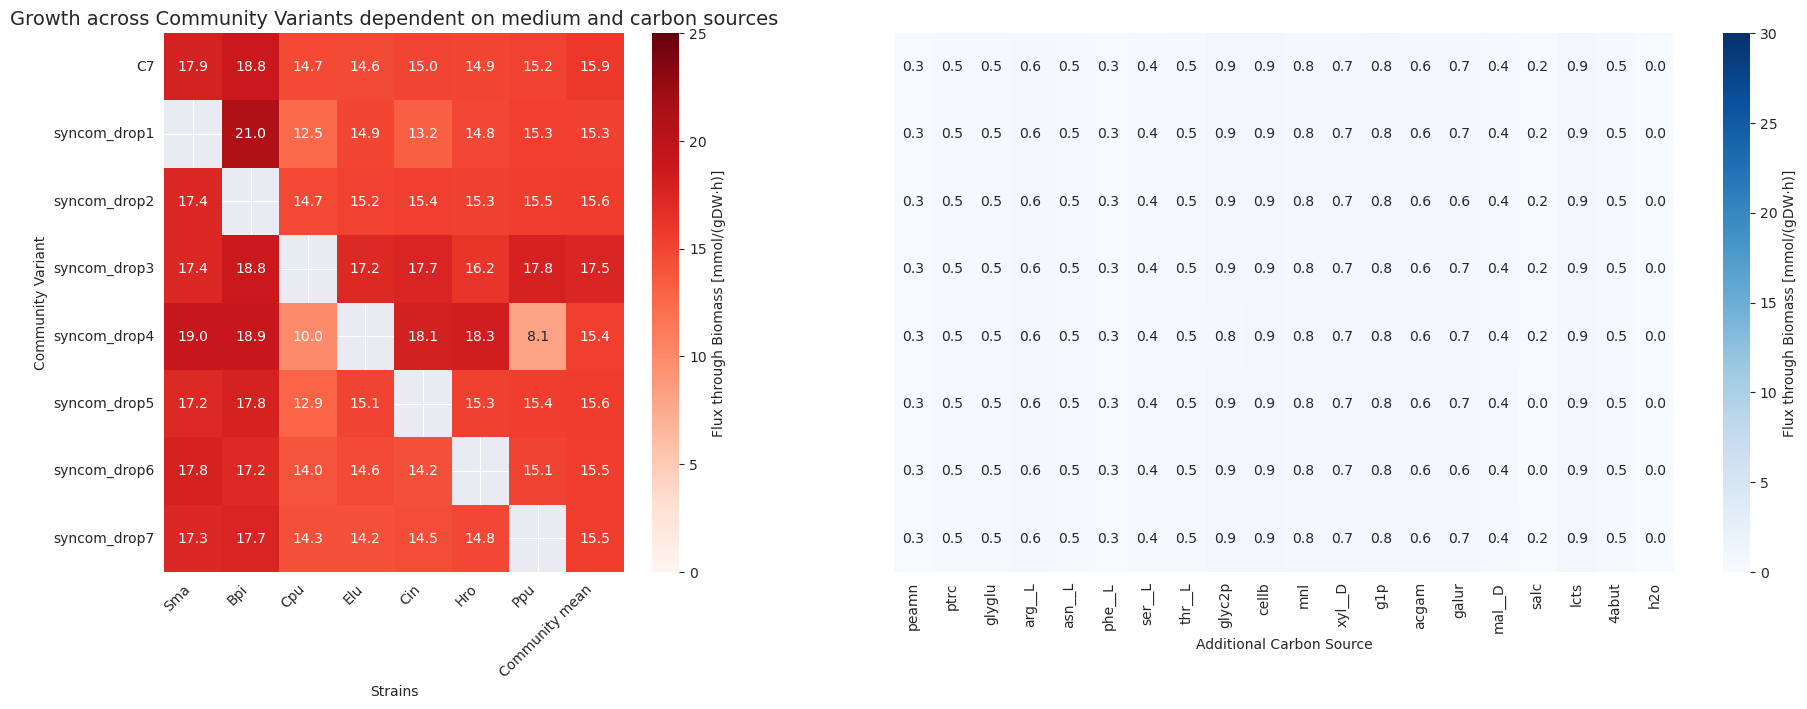

In [29]:
fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(22, 7),
    sharey=True,
    gridspec_kw={'width_ratios': [1, 1.7]}
)

vmin = 0
vmax = 45
color_map1 = "Reds"
color_map2 = "Blues"

# --- First heatmap: Growth ---
sns.heatmap(
    growth_with_total,
    ax=ax1,
    cmap=color_map1,
    annot=True,
    fmt=".1f",
    vmin=0,
    vmax=25,
    cbar=True,
    cbar_kws={'label': 'Flux through Biomass [mmol/(gDW·h)]'}
)
ax1.set_ylabel("Community Variant")
ax1.set_xlabel("Strains")
ax1.set_title("Growth across Community Variants dependent on medium and carbon sources", fontsize=14)
ax1.set_xticklabels(custom_labels_x, rotation=45, ha="right")
ax1.set_yticklabels(custom_labels_y, ha="right")

# --- Second heatmap: Metabolite Uptake ---
res_df_clean = res_df_avg[[res_df_avg.columns[-1]] + list(res_df_avg.columns[:-1])]
res_df_clean = res_df_clean.drop(index="4hbz", errors="ignore").fillna(0)
res_df_clean_T = res_df_clean.T

heatmap = sns.heatmap(
    res_df_clean_T,
    ax=ax2,
    cmap=color_map2,
    vmin=0,
    vmax=30,
    annot=True,
    fmt=".1f",
    cbar=True,
    cbar_kws={'label': 'Flux through Biomass [mmol/(gDW·h)]'}
)
ax2.set_xlabel("Additional Carbon Source")
#ax2.set_title("Metabolite Uptake across Community Variants", fontsize=14)
ax2.set_xticklabels(metab_axis, rotation=45, ha="right")
ax2.set_yticklabels(custom_labels_y, ha="right")  # Y is shared with ax1

# --- Shared colorbar ---
#cbar_ax = fig.add_axes([0.93, 0.25, 0.02, 0.5])
#fig.colorbar(heatmap.get_children()[0], cax=cbar_ax, label="Flux through Biomass\n[mmol/(gDW·h)]")

# --- Global super title ---
#fig.suptitle("Growth across Community Variants on", fontsize=16, fontweight='bold', y=0.98, x=0.42)

# --- Individual titles for each subplot ---
ax1.set_title("(a) Growth across Community Variants on Maize Root Exudate", fontsize=13)
ax2.set_title("(b) Growth across Community Variants on M9 Minimal Medium", fontsize=13)

# --- Layout ---
#plt.tight_layout(rect=[0, 0, 0.92, 1])
fig.subplots_adjust(wspace=0.05)

# --- Save & Show ---
plt.savefig("../Figures/combined_heatmap.svg", format="svg", bbox_inches="tight")
plt.show()


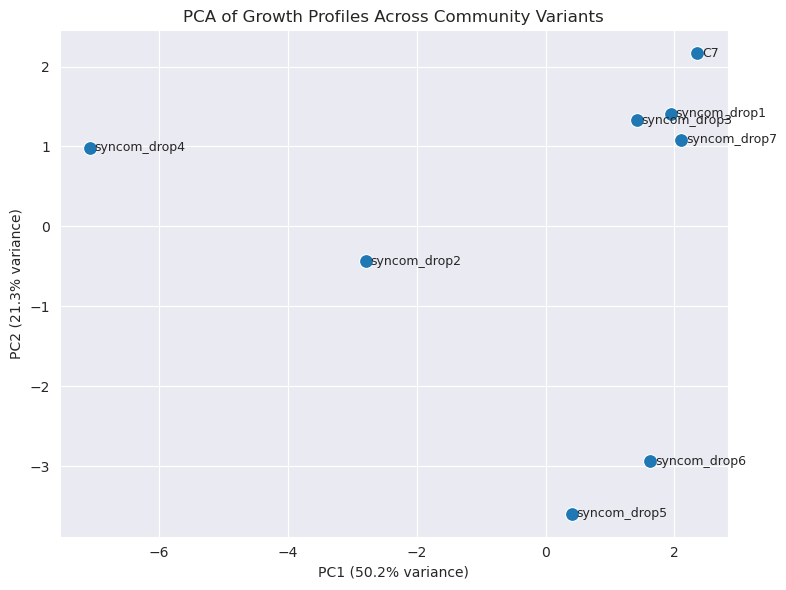

In [30]:
# Standardise the data
scaler = StandardScaler()
growth_df_filled = res_df_clean.T.fillna(0)
scaled_growth = scaler.fit_transform(growth_df_filled)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_growth)

# Create df for PCA result
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"], index=res_df_clean.T.index)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", data=pca_df, s=100)

# Annotate each point with the community name
for name, row in pca_df.iterrows():
    if name != "C7_Community":
        plt.text(row["PC1"] + 0.07, row["PC2"]-0.04, name, fontsize=9)
    else:
        plt.text(row["PC1"] + -0.1, row["PC2"]+0.1, name, fontsize=9)

# Add variance explained info
pc1_var = pca.explained_variance_ratio_[0] * 100
pc2_var = pca.explained_variance_ratio_[1] * 100
plt.xlabel(f"PC1 ({pc1_var:.1f}% variance)")
plt.ylabel(f"PC2 ({pc2_var:.1f}% variance)")

plt.title("PCA of Growth Profiles Across Community Variants")
#plt.xlim(-3, 3)
#plt.ylim(-3, 2)
plt.grid(True)
plt.tight_layout()
#plt.savefig("../Figures/drop_outs_ecoplate_pca.svg", format="svg", bbox_inches="tight")
plt.show()

# Uptakes and Secretions

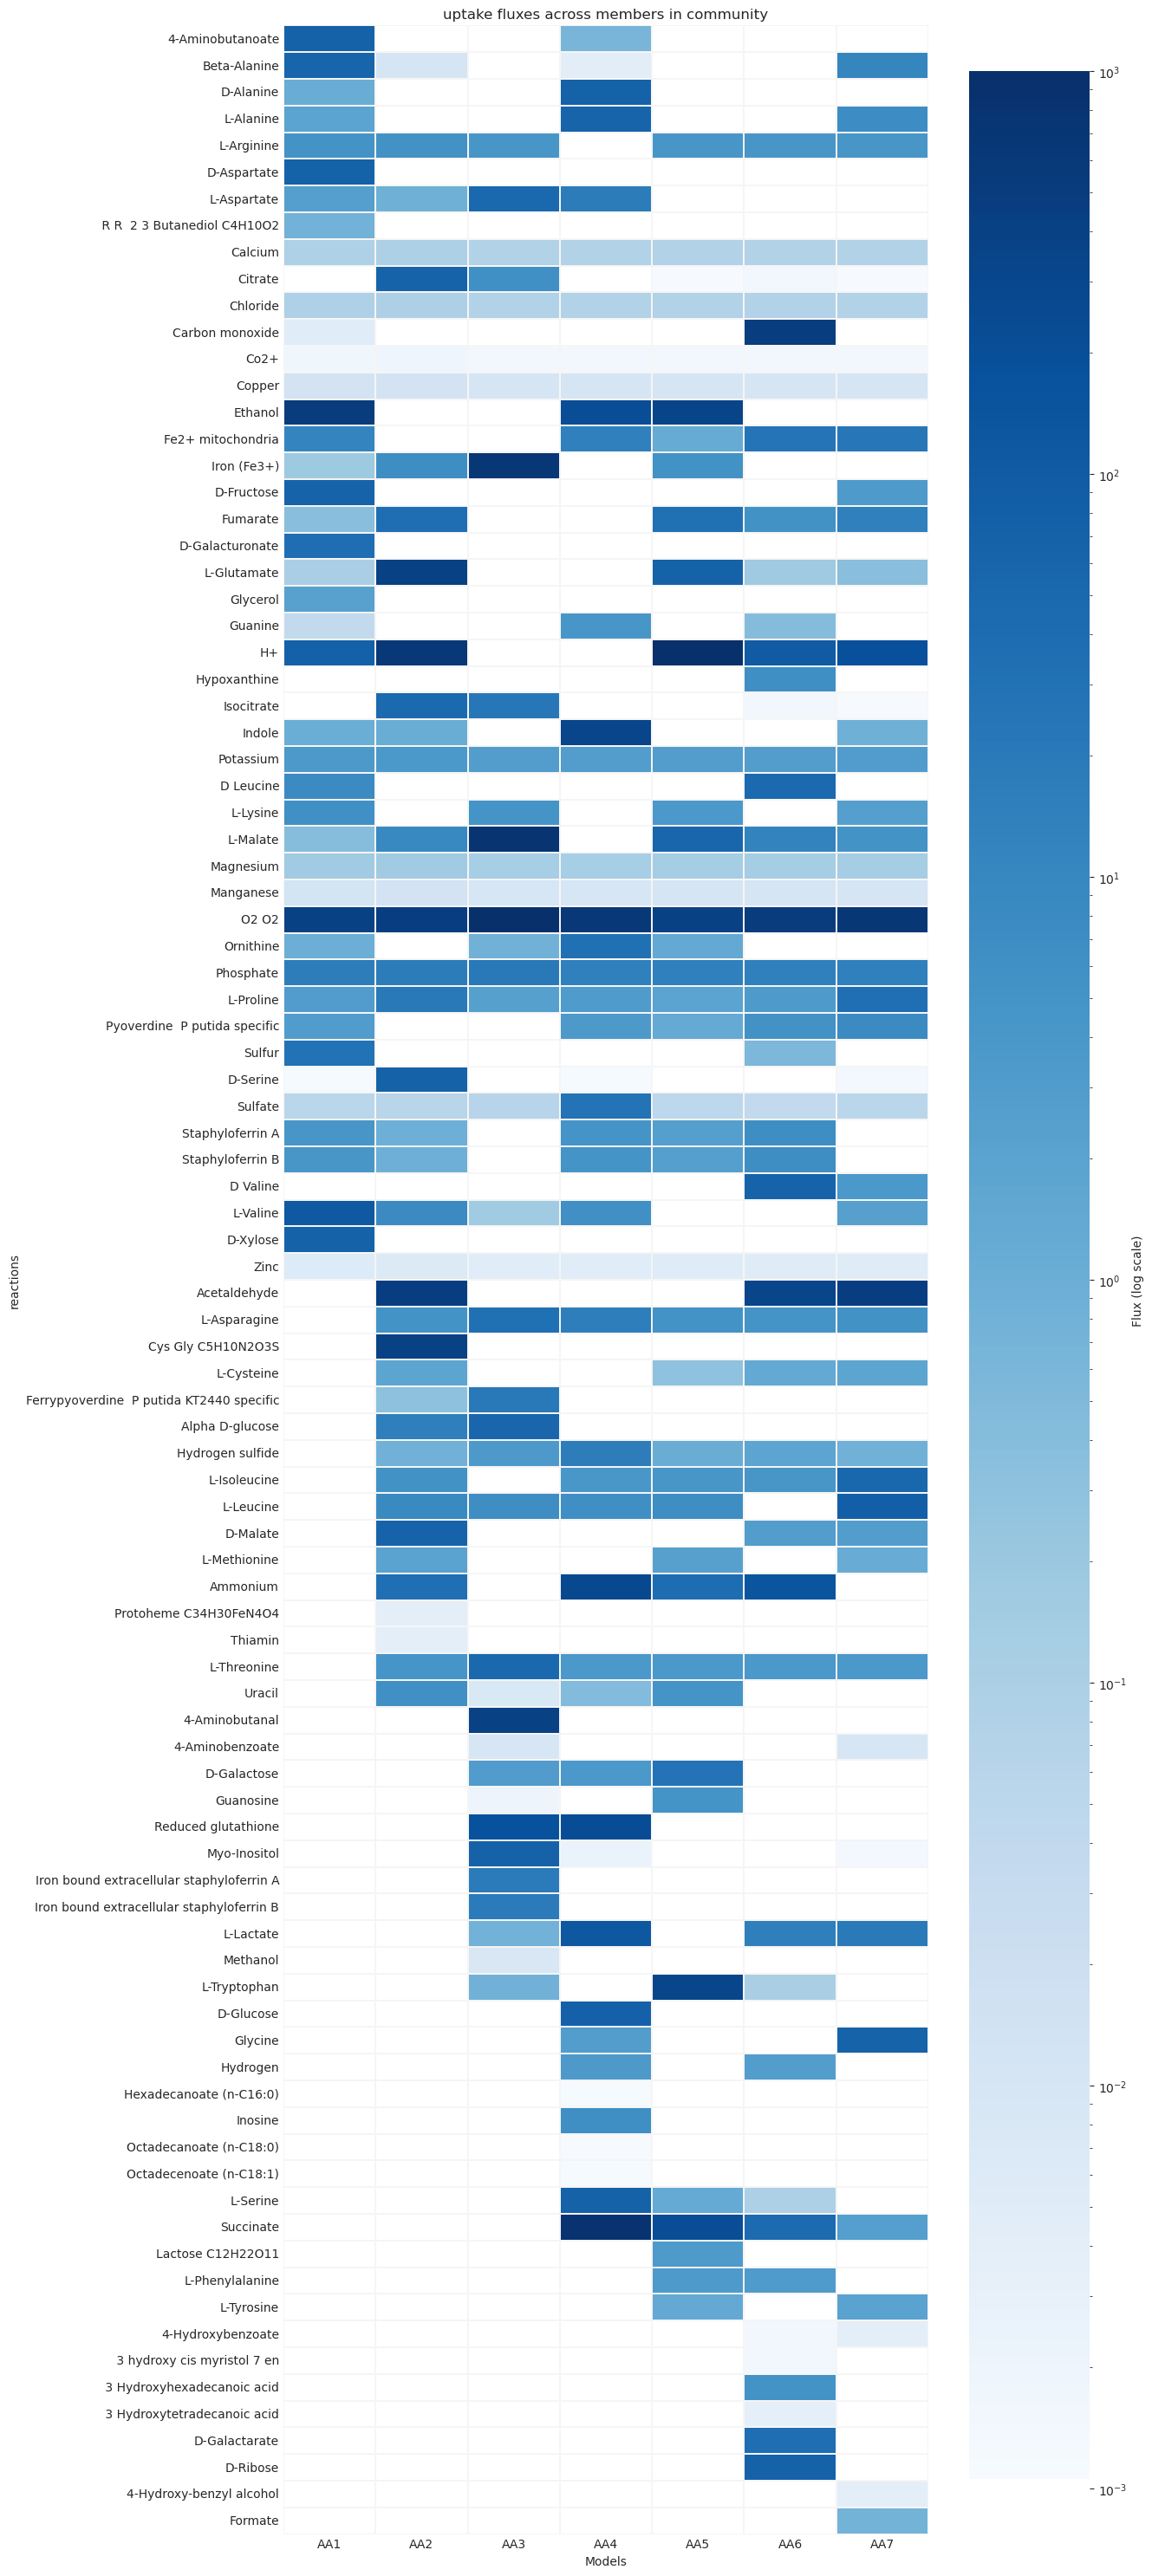

In [36]:
heatmap_fluxes_withinCommunity(syncom, models, medium_combined_krumbach, "uptake")

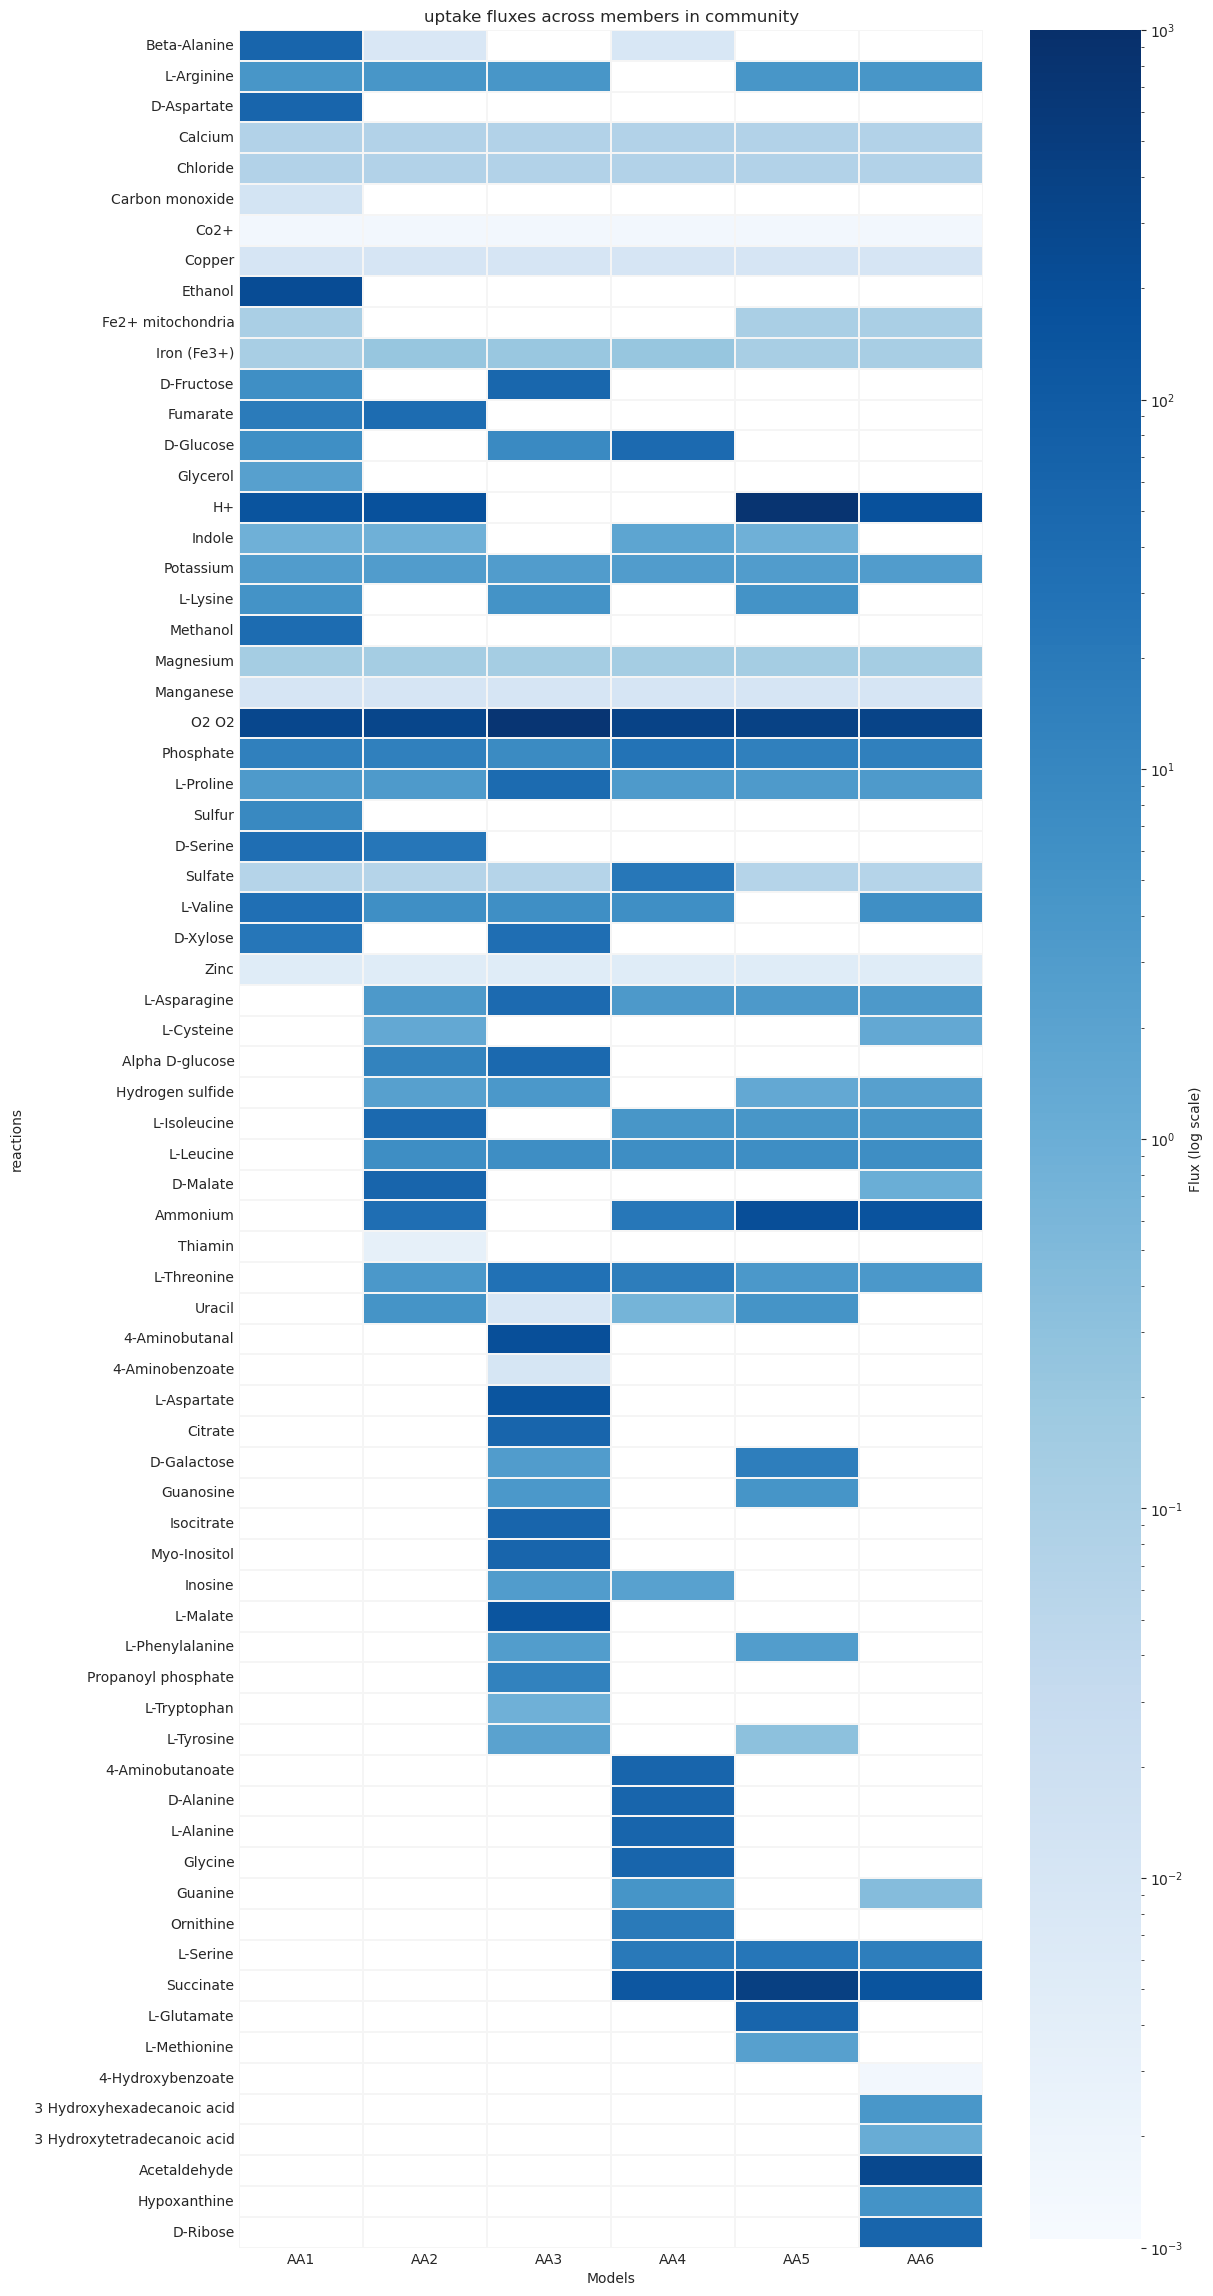

In [35]:
new_dict = {k: v for k, v in models.items() if k != "AA7"}
heatmap_fluxes_withinCommunity(S7, new_dict, medium_combined_krumbach, "uptake")

In [40]:
syncom.reactions.query("EX_thm")

[<Reaction EX_thm_e__AA2 at 0x77497a8f2080>,
 <Reaction EX_thm_m at 0x7749790173a0>,
 <Reaction EX_thm_e__AA3 at 0x774978e8a980>,
 <Reaction EX_thm_e__AA4 at 0x774973e614e0>,
 <Reaction EX_thm_e__AA5 at 0x77497201d6f0>,
 <Reaction EX_thm_e__AA7 at 0x77496b956ec0>]

In [49]:
get_rxn(AA4, "PFL")

PFL: coa_c + pyr_c --> accoa_c + for_c


In [50]:
get_rxn_unknown(models, "PFL")

PFL is found in: ['AA4']
PFL: coa_c + pyr_c --> accoa_c + for_c


In [47]:
get_met(AA4, "for_c")

Formate (CHO2)
{'SFGTHi': 'Sfglutth_c + h2o_c --> for_c + gthrd_c + h_c', 'ALDD1': 'fald_c + h2o_c + nad_c --> for_c + 2.0 h_c + nadh_c', 'FORAMD': 'frmd_c + h2o_c --> for_c + nh4_c', 'FORtppi': 'for_c --> for_p', 'FORt2pp': 'for_p + h_p --> for_c + h_c', 'PFL': 'coa_c + pyr_c --> accoa_c + for_c', 'FTHFD': '10fthf_c + h2o_c --> for_c + h_c + thf_c', 'ARD_1': 'dhmtp_c + o2_c --> 2kmb_c + for_c + 2.0 h_c', 'OBTFL': '2obut_c + coa_c --> for_c + ppcoa_c', 'DB4PS': 'ru5p__D_c --> db4p_c + for_c + h_c', 'AMPMS2': 'air_c + h2o_c + nad_c --> 4ampm_c + 2.0 for_c + 3.0 h_c + nadh_c', 'FDH': 'for_c + nad_c --> co2_c + nadh_c', 'OXFOt4pp': 'for_c + oxa_p <=> for_p + oxa_c', 'GART': 'atp_c + for_c + gar_c --> adp_c + fgam_c + h_c + pi_c', 'GTPCI': 'gtp_c + h2o_c --> ahdt_c + for_c + h_c', 'GTPCII2': 'gtp_c + 3.0 h2o_c --> 25drapp_c + for_c + 2.0 h_c + ppi_c'}


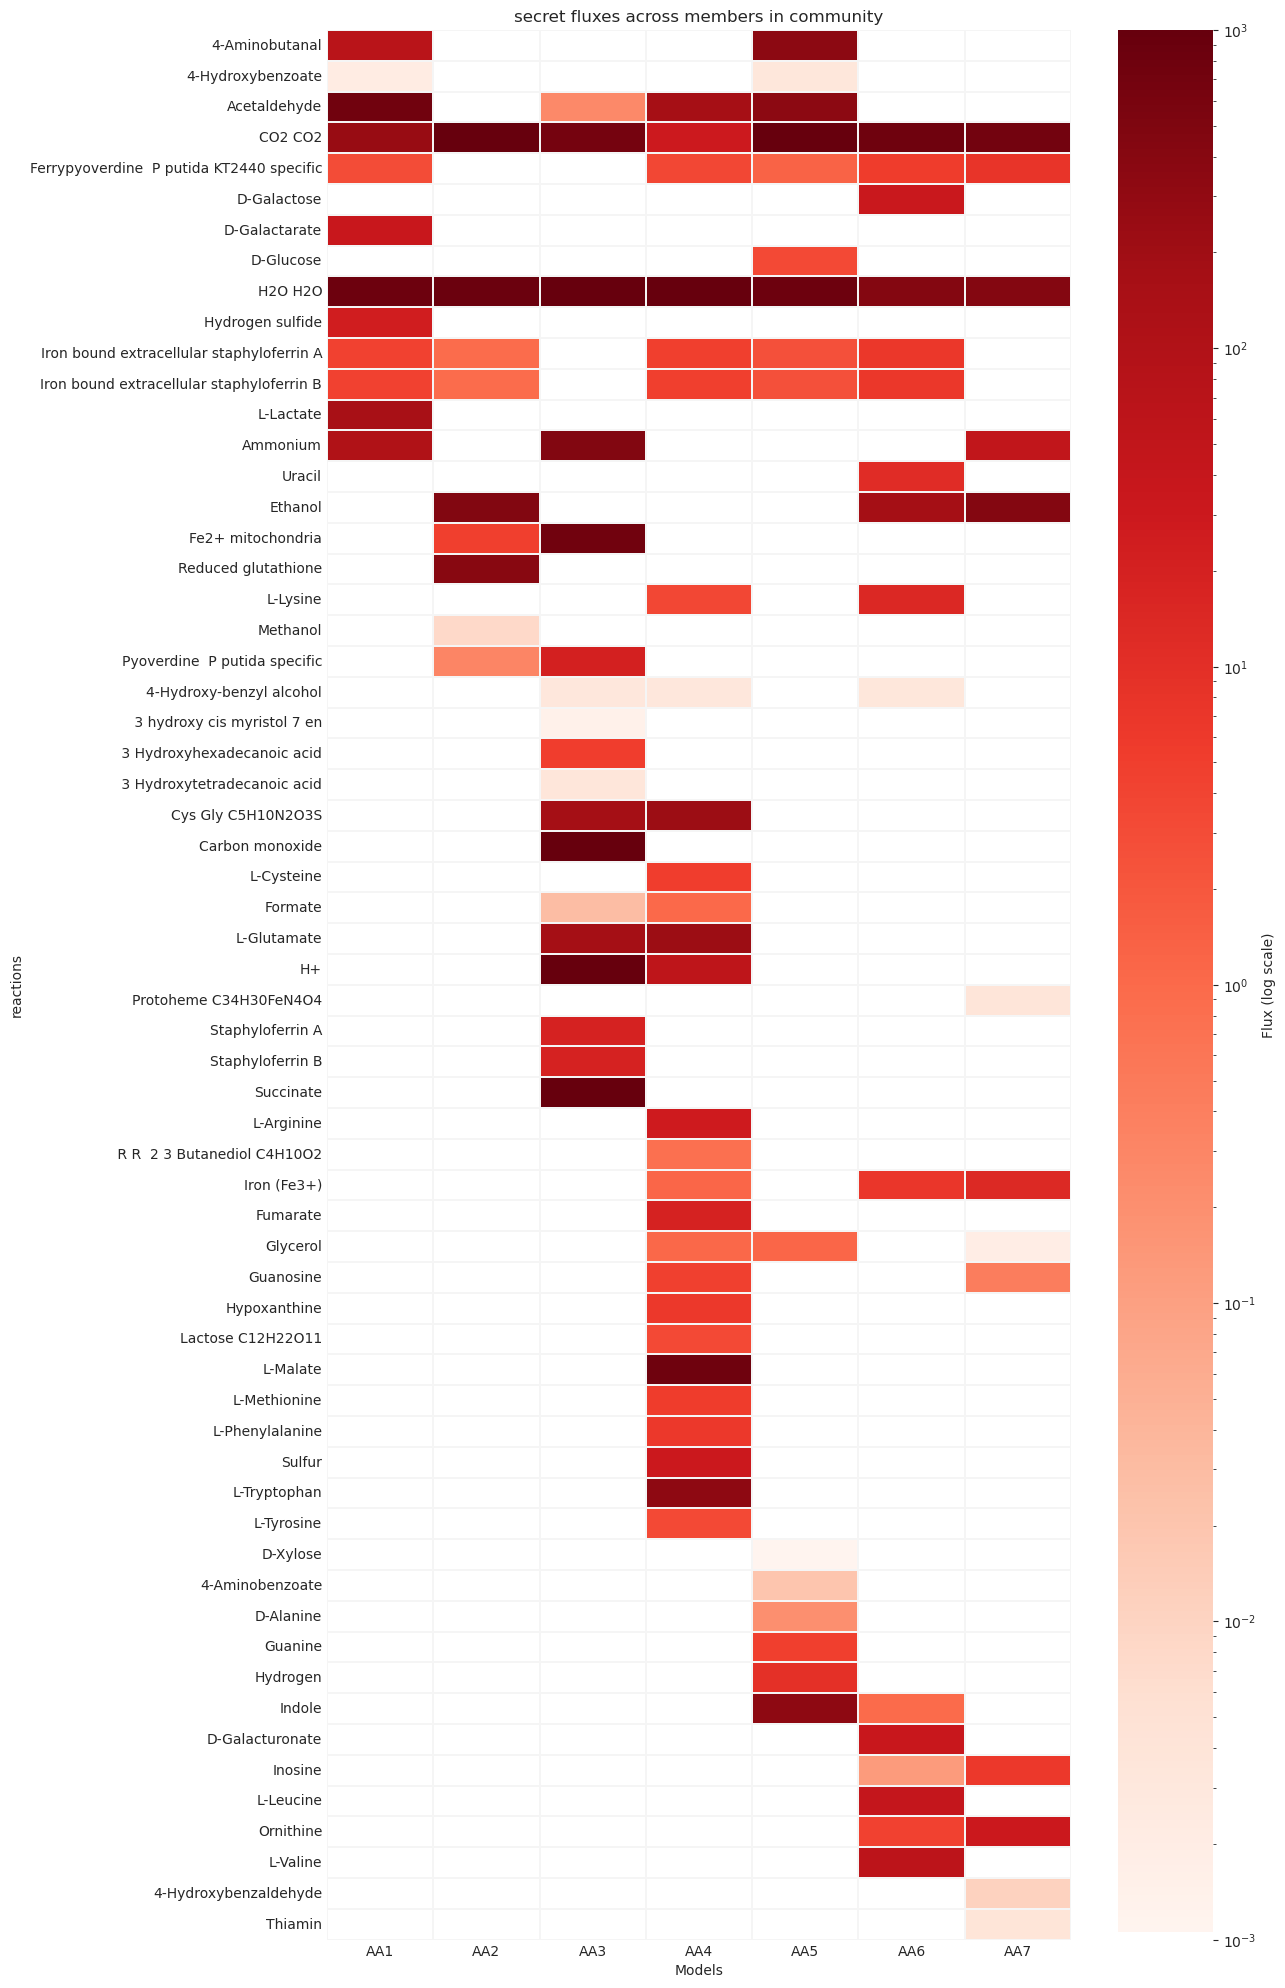

In [37]:
heatmap_fluxes_withinCommunity(syncom, models, medium_combined_krumbach, "secret")

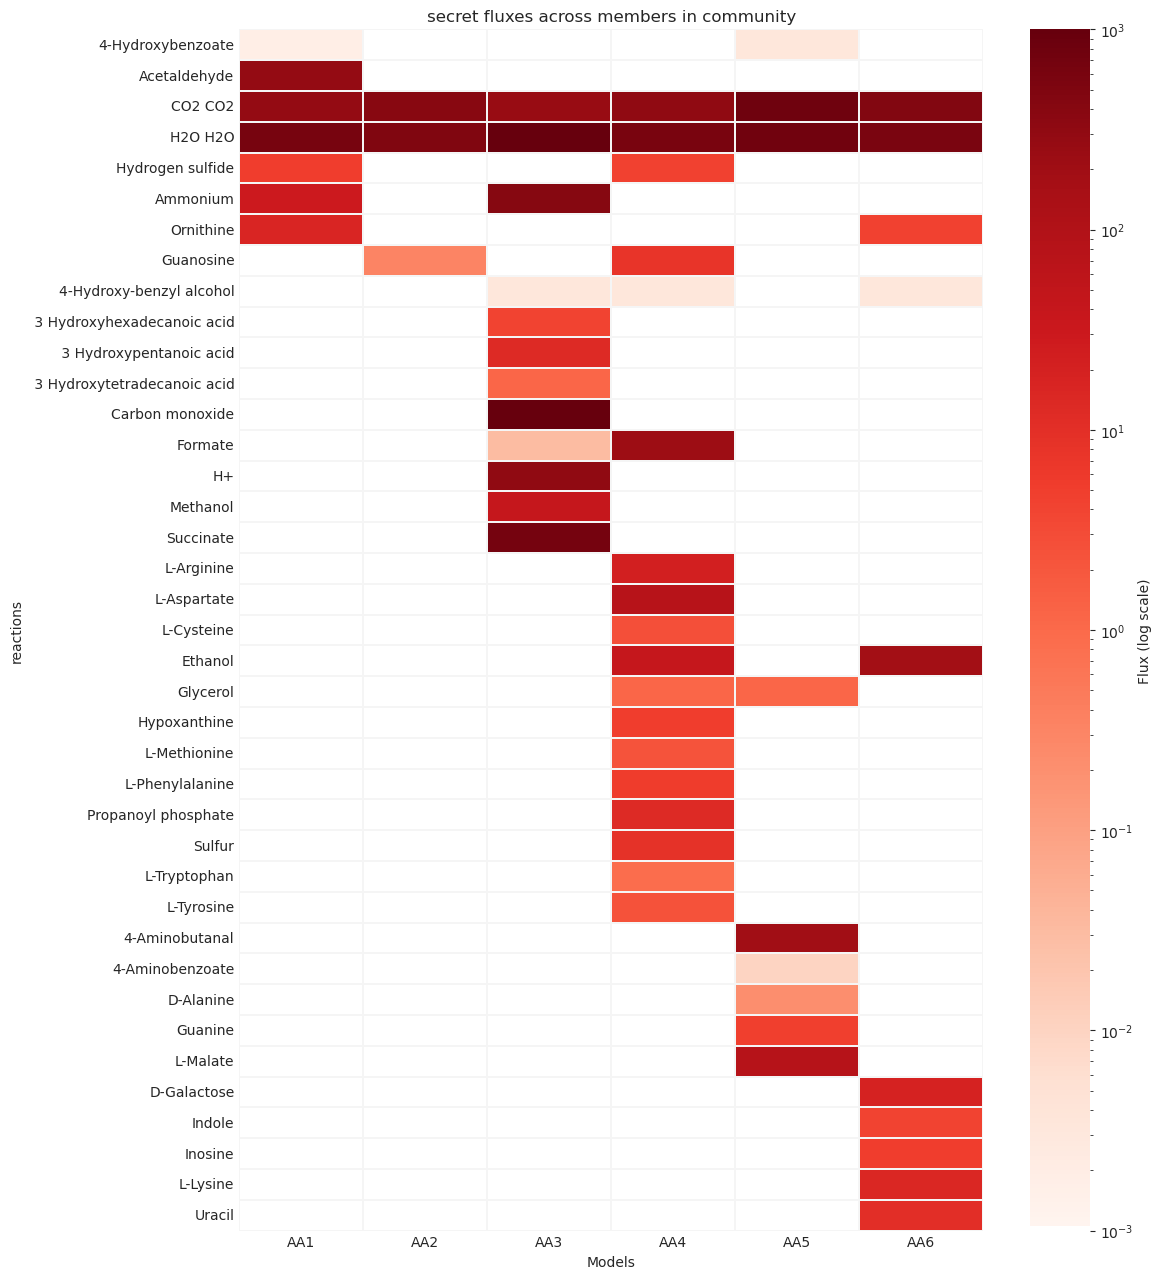

In [38]:
heatmap_fluxes_withinCommunity(S7, new_dict, medium_combined_krumbach, "secret")

# Spielplatz

In [39]:
S7_flux, S7_growth = community_pfba(S7, medium_combined_krumbach)

In [23]:
S7_growth

model
AA1    15.097689
AA2    15.086133
AA3    15.097689
AA4    15.097689
AA5    15.097689
AA6    15.097689
Name: Growth, dtype: float64

In [43]:
C7_flux, C7_growth = community_pfba(syncom, medium_combined_krumbach)

In [29]:
C7_growth

model
AA1    17.872157
AA2    18.809741
AA3    14.676299
AA4    14.640428
AA5    15.018397
AA6    14.938410
AA7    15.187845
Name: Growth, dtype: float64

In [44]:
C7_df_reset = C7_flux.reset_index().rename(columns={"reaction": "rxn_id"})
S7_df_reset = S7_flux.reset_index().rename(columns={"reaction": "rxn_id"})


In [45]:
merged = C7_df_reset.merge(S7_df_reset, on="rxn_id", suffixes=("_C7", "_S7"))

# Compare medium fluxes
merged["medium_diff"] = merged["medium_C7"] - merged["medium_S7"]

# Compare per-organism fluxes (excluding the dropped strain)
for strain in [col for col in C7_flux.columns if col != "AA7" and col != "medium"]:
    merged[f"{strain}_diff"] = merged[f"{strain}_C7"] - merged[f"{strain}_S7"]

# Find where changes happened
diff_cols = [c for c in merged.columns if c.endswith("_diff")]
# Sum the absolute differences for each reaction
flux_changes = merged[diff_cols].abs().sum(axis=1)
flux_changes.name = "total_abs_diff"  # give it a proper name

# Filter for reactions with changes
changed_rxns = merged.loc[flux_changes > 1e-6, ["rxn_id"] + diff_cols]

# Add the diff magnitude as a column for sorting
changed_rxns["total_abs_diff"] = flux_changes[flux_changes > 1e-6]

# Sort by magnitude
changed_rxns = changed_rxns.sort_values(by="total_abs_diff", ascending=False)

In [46]:
# Identify the AA columns (excluding medium)
aa_cols = [c for c in C7_flux.columns if c.startswith("AA")]

# Filter: only EX_ reactions
mask_ex = C7_flux.index.str.startswith("EX_")

# Condition 1: AA7 > 0
mask_aa7_pos = C7_flux["AA7"] > 0

# Condition 2: all other AA's < 0
other_aas = [c for c in aa_cols if c != "AA7"]
mask_others_neg = (C7_flux[other_aas] < 0).all(axis=1)

# Combine masks
mask = mask_ex & mask_aa7_pos & mask_others_neg

# Get the matching reactions
aa7_only_prod = C7_flux.loc[mask]

print(aa7_only_prod.index)


Index(['EX_g3pc_e'], dtype='object', name='reaction')


In [104]:
get_met_unknown(models, "g3pc_e")

g3pc_e (Sn-Glycero-3-phosphocholine (C8H20NO6P, 0)) is found  models: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7'] and in reactions: {'G3PCtex', 'EX_g3pc_e', 'GPDDA1_1'}


In [71]:
get_rxn_unknown(models, "G3PCtex")

G3PCtex is found in: ['AA1', 'AA2', 'AA3', 'AA4', 'AA6']
G3PCtex: g3pc_e <=> g3pc_p


In [72]:
get_rxn_unknown(models, "GPDDA1_1")

GPDDA1_1 is found in: ['AA2', 'AA5', 'AA7']
GPDDA1_1: g3pc_e + h2o_e --> chol_e + glyc3p_e + h_e


In [ ]:
get_met_unknown(models, "g3pc_e")

In [73]:
get_rxn_unknown(models, "EX_g3pc_e")

EX_g3pc_e is found in: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7']
EX_g3pc_e: g3pc_e <=> 


In [74]:
get_met_unknown(models, "chol_e")

chol_e (Choline C5H14NO (C5H14NO, 1)) is found  models: ['AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7'] and in reactions: {'CHLabc_rev', 'CHLabc', 'CHLt2', 'GPDDA1_1', 'CHLtex', 'EX_chol_e'}
